In [1]:
# importing the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading in the data file
corona = pd.read_csv("./Data/covid19-in-india/covid_19_india.csv", parse_dates = [1], dayfirst = True)

# dropping the columns which don't add to the analysis
corona = corona.drop(["Sno", "Time", "State/UnionTerritory"], axis = 1)

# converting "Date" into Datetime format
corona["Date"] = pd.to_datetime(corona["Date"])

In [3]:
# grouping the cases by date for easier analysis
datewise = corona.groupby(["Date"]).agg({"ConfirmedIndianNational": 'sum', "ConfirmedForeignNational": 'sum', "Cured": "sum", "Deaths":'sum'})

# making the "Date" column part of the database
datewise["Date"] = datewise.index

# making the index column
ind = []
for i in range(len(datewise)):
    ind.append(i)
datewise["Index"] = ind
datewise.set_index("Index", inplace = True)

# resetting DataFrame with columns in desired order
datewise = datewise[["Date", "ConfirmedIndianNational", "ConfirmedForeignNational", "Cured", "Deaths"]]

In [4]:
# adding a new column to the database which counts the days since the first case was reported
datewise["Days Since"] = datewise["Date"] - datewise["Date"][0]
datewise["Days Since"] = datewise["Days Since"].dt.days

# removing the "Date" column
datewise = datewise.drop(["Date"], axis = 1)

# removing the rows with entries that are not integers
to_remove = []
for idx, i in datewise.iterrows():
    try:
        k = int(i["ConfirmedIndianNational"])
    except:
        to_remove.append(idx)
datewise = datewise.drop(to_remove)

# printing the DataFrame with the new "Days Since" columns added
print(datewise)

       ConfirmedIndianNational  ConfirmedForeignNational  Cured  Deaths  \
Index                                                                     
0                            1                         0      0       0   
1                            1                         0      0       0   
2                            2                         0      0       0   
3                            3                         0      0       0   
4                            3                         0      0       0   
5                            3                         0      0       0   
6                            3                         0      0       0   
7                            3                         0      0       0   
8                            3                         0      0       0   
9                            3                         0      0       0   
10                           3                         0      0       0   
11                       

# Time Series Forecasting

## Holt's Linear Model

In [5]:
# importing the requisite libraries and making the train, validation data and an emoty list to store the model's MSE
from statsmodels.tsa.api import Holt
from datetime import timedelta

train_ml = datewise.iloc[: int(datewise.shape[0] * 0.85)]
valid_ml = datewise.iloc[int(datewise.shape[0] * 0.85):]
model_scores = []

In [6]:
import numpy as np

# training the model
holt = Holt(np.asarray(train_ml["ConfirmedIndianNational"])).fit(smoothing_level = 1.3, smoothing_slope = 1.1)
y_pred = valid_ml.copy()

In [7]:
from sklearn.metrics import mean_squared_error

# printing the root mean square error
y_pred["Holt"] = holt.forecast(len(valid_ml))
model_scores.append(np.sqrt(mean_squared_error(y_pred["ConfirmedIndianNational"], y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ", np.sqrt(mean_squared_error(y_pred["ConfirmedIndianNational"], y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  250.49146813212178


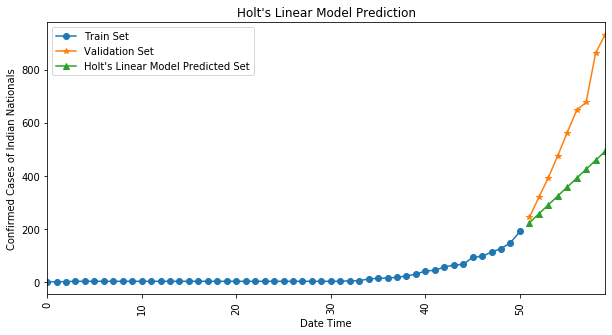

In [8]:
# plotting the predictions by the model
plt.figure(figsize = (10,5))
plt.plot(train_ml.ConfirmedIndianNational,label = "Train Set", marker = 'o')
valid_ml.ConfirmedIndianNational.plot(label = "Validation Set", marker = '*')
y_pred.Holt.plot(label = "Holt's Linear Model Predicted Set", marker = '^')
plt.ylabel("Confirmed Cases of Indian Nationals")
plt.xlabel("Date Time")
plt.xticks(rotation = 90)
plt.title("Holt's Linear Model Prediction")
plt.legend()

## Holt's Winter Model for Daily Time Series

In [9]:
from statsmodels.tsa.api import ExponentialSmoothing

# making and training the model
es = ExponentialSmoothing(np.asarray(train_ml['ConfirmedIndianNational']), seasonal_periods = 4, trend='mul', seasonal = 'add').fit()

In [10]:
# making the predictions
y_pred["Holt's Winter Model"] = es.forecast(len(valid_ml))

In [11]:
# printing the root mean square error
model_scores.append(np.sqrt(mean_squared_error(y_pred["ConfirmedIndianNational"], y_pred["Holt's Winter Model"])))
print("Root Mean Square Error for Holt's Winter Model: ", np.sqrt(mean_squared_error(y_pred["ConfirmedIndianNational"], y_pred["Holt's Winter Model"])))

Root Mean Square Error for Holt's Winter Model:  117.1246093883104


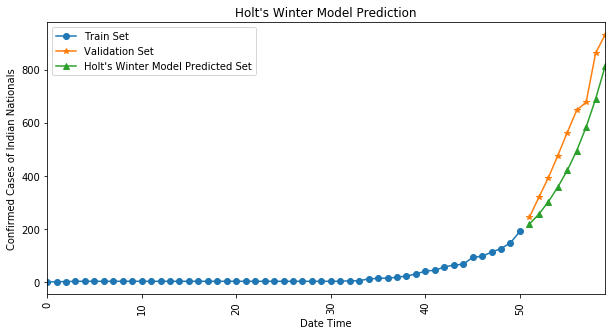

In [12]:
# plotting the predictions by the model
plt.figure(figsize = (10,5))
plt.plot(train_ml.ConfirmedIndianNational,label = "Train Set", marker = 'o')
valid_ml.ConfirmedIndianNational.plot(label = "Validation Set", marker = '*')
y_pred["Holt\'s Winter Model"].plot(label = "Holt's Winter Model Predicted Set", marker = '^')
plt.ylabel("Confirmed Cases of Indian Nationals")
plt.xlabel("Date Time")
plt.xticks(rotation = 90)
plt.title("Holt's Winter Model Prediction")
plt.legend()

## AR (Auto Regressive Model) Model

In [13]:
from statsmodels.tsa.arima_model import ARIMA

# making and training the model
log_series = np.log(train_ml["ConfirmedIndianNational"])
model_ar = ARIMA(log_series, (10, 2, 2))
model_ar_fit = model_ar.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [14]:
# making the predictions
prediction_ar = model_ar_fit.forecast(len(valid_ml))[0]
y_pred["AR Model Prediction"] = list(np.exp(prediction_ar))

In [15]:
# printing the root mean square error
model_scores.append(np.sqrt(mean_squared_error(list(valid_ml["ConfirmedIndianNational"]), np.exp(prediction_ar))))
print("Root Mean Square Error for AR Model: ", np.sqrt(mean_squared_error(list(valid_ml["ConfirmedIndianNational"]), np.exp(prediction_ar))))

Root Mean Square Error for AR Model:  61.16887135466584


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 <a list of 9 Text xticklabel objects>)

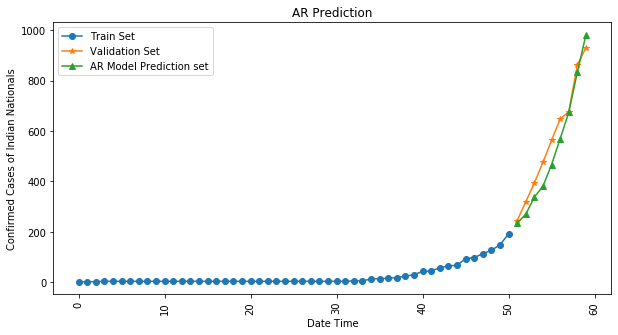

In [16]:
# plotting the predictions by the model
plt.figure(figsize = (10, 5))
plt.plot(train_ml.index, train_ml["ConfirmedIndianNational"], label = "Train Set", marker = 'o')
plt.plot(valid_ml.index, valid_ml["ConfirmedIndianNational"], label = "Validation Set", marker = '*')
plt.plot(y_pred["AR Model Prediction"], label = "AR Model Prediction set", marker = "^")
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases of Indian Nationals')
plt.title("AR Prediction")
plt.xticks(rotation = 90)

## MA (Moving Average) Model

In [17]:
# making and training the model
log_series = np.log(train_ml["ConfirmedIndianNational"])
model_ma = ARIMA(log_series, (10, 2, 2))
model_ma_fit = model_ma.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [18]:
# making the predictions
prediction_ma = model_ma_fit.forecast(len(valid_ml))[0]
y_pred["MA Model Prediction"] = list(np.exp(prediction_ma))

In [19]:
# printing the root mean square error
model_scores.append(np.sqrt(mean_squared_error(list(valid_ml["ConfirmedIndianNational"]), np.exp(prediction_ma))))
print("Root Mean Square Error for MA Model: ", np.sqrt(mean_squared_error(list(valid_ml["ConfirmedIndianNational"]), np.exp(prediction_ma))))

Root Mean Square Error for MA Model:  61.16887135466584


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 <a list of 9 Text xticklabel objects>)

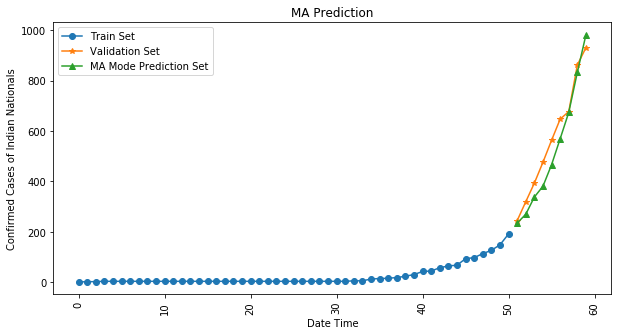

In [20]:
# plotting the predictions by the model
plt.figure(figsize = (10, 5))
plt.plot(train_ml.index, train_ml["ConfirmedIndianNational"], label = "Train Set", marker = 'o')
plt.plot(valid_ml.index, valid_ml["ConfirmedIndianNational"], label = "Validation Set", marker = '*')
plt.plot(y_pred["MA Model Prediction"], label = "MA Mode Prediction Set", marker = '^')
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases of Indian Nationals')
plt.title("MA Prediction")
plt.xticks(rotation=90)

## ARIMA Model

In [21]:
# making and training the model
log_series = np.log(train_ml["ConfirmedIndianNational"])
model_arima = ARIMA(log_series, (10, 2, 2))
model_arima_fit = model_arima.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [22]:
# making the predictions
prediction_arima = model_arima_fit.forecast(len(valid_ml))[0]
y_pred["ARIMA Model Prediction"] = list(np.exp(prediction_arima))

In [23]:
# printing the root mean square error
model_scores.append(np.sqrt(mean_squared_error(list(valid_ml["ConfirmedIndianNational"]), np.exp(prediction_arima))))
print("Root Mean Square Error for ARIMA Model: ", np.sqrt(mean_squared_error(list(valid_ml["ConfirmedIndianNational"]), np.exp(prediction_arima))))

Root Mean Square Error for ARIMA Model:  61.16887135466584


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 <a list of 9 Text xticklabel objects>)

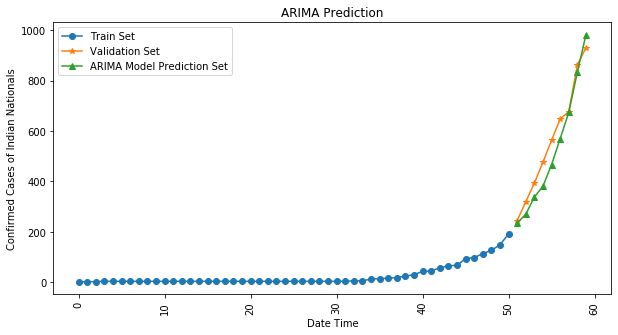

In [24]:
# plotting the predictions by the model
plt.figure(figsize = (10, 5))
plt.plot(train_ml.index, train_ml["ConfirmedIndianNational"], label = "Train Set", marker = 'o')
plt.plot(valid_ml.index, valid_ml["ConfirmedIndianNational"], label = "Validation Set", marker = '*')
plt.plot(y_pred["ARIMA Model Prediction"], label = "ARIMA Model Prediction Set", marker = '^')
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases of Indian Nationals')
plt.title("ARIMA Prediction")
plt.xticks(rotation = 90)

# Machine Learning Algorithms

## Linear Regression

In [25]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1), np.array(train_ml["ConfirmedIndianNational"]).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
# making the predictions
prediction_valid_linreg = lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
y_pred["Linear Regression Model Prediction"] = list(prediction_valid_linreg)

In [27]:
# printing the root mean square error
model_scores.append(np.sqrt(mean_squared_error(valid_ml["ConfirmedIndianNational"], prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ", np.sqrt(mean_squared_error(valid_ml["ConfirmedIndianNational"], prediction_valid_linreg)))

Root Mean Square Error for Linear Regression:  527.4642355351867


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 <a list of 9 Text xticklabel objects>)

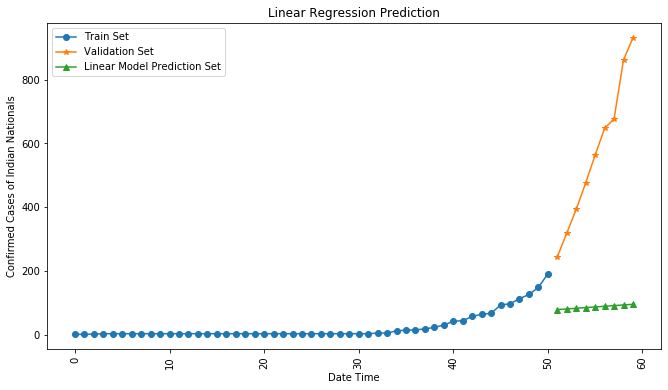

In [28]:
# plotting the predictions by the model
plt.figure(figsize = (11, 6))
plt.plot(train_ml.index, train_ml["ConfirmedIndianNational"], label = "Train Set", marker = 'o')
plt.plot(valid_ml.index, valid_ml["ConfirmedIndianNational"], label = "Validation Set", marker = '*')
plt.plot(y_pred["Linear Regression Model Prediction"], label = "Linear Model Prediction Set", marker = '^')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('Confirmed Cases of Indian Nationals')
plt.title("Linear Regression Prediction")
plt.xticks(rotation = 90)

## Polynomial Regression

In [29]:
# importing the requisite library and making and training the model
from sklearn.preprocessing import PolynomialFeatures 

poly_reg = PolynomialFeatures(degree = 7) 
X_poly = poly_reg.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
poly_reg.fit(X_poly, np.array(train_ml["ConfirmedIndianNational"]).reshape(-1,1))

lin2 = LinearRegression() 
lin2.fit(X_poly, np.array(train_ml["ConfirmedIndianNational"]).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
# making the predictions
prediction_valid_polyreg = lin2.predict(poly_reg.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1)))
y_pred["Polynomial Regression Model Prediction"] = list(prediction_valid_polyreg)

In [31]:
# printing the root mean square error
model_scores.append(np.sqrt(mean_squared_error(valid_ml["ConfirmedIndianNational"], prediction_valid_polyreg)))
print("Root Mean Square Error for Polynomial Regression: ", np.sqrt(mean_squared_error(valid_ml["ConfirmedIndianNational"], prediction_valid_polyreg)))

Root Mean Square Error for Polynomial Regression:  75.84607500168111


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 <a list of 9 Text xticklabel objects>)

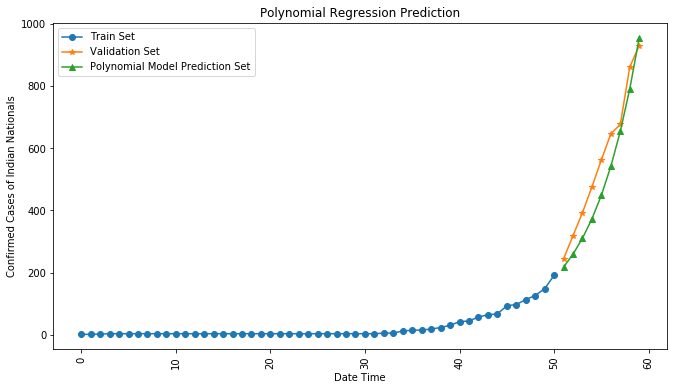

In [32]:
# plotting the predictions by the model
plt.figure(figsize = (11, 6))
plt.plot(train_ml.index, train_ml["ConfirmedIndianNational"], label = "Train Set", marker = 'o')
plt.plot(valid_ml.index, valid_ml["ConfirmedIndianNational"], label = "Validation Set", marker = '*')
plt.plot(y_pred["Polynomial Regression Model Prediction"], label = "Polynomial Model Prediction Set", marker = '^')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('Confirmed Cases of Indian Nationals')
plt.title("Polynomial Regression Prediction")
plt.xticks(rotation = 90)

## LASSO Regression

In [33]:
# importing the requisite library and making and training the model
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha = 0.000000000000000000001)
lasso_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1), np.array(train_ml["ConfirmedIndianNational"]).reshape(-1,1))

Lasso(alpha=1e-21, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [34]:
# making the predictions
prediction_valid_lassoreg = lasso_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
y_pred["LASSO Regression Model Prediction"] = list(prediction_valid_lassoreg)

In [35]:
# printing the root mean square error
model_scores.append(np.sqrt(mean_squared_error(valid_ml["ConfirmedIndianNational"], prediction_valid_lassoreg)))
print("Root Mean Square Error for Lasso Regression: ", np.sqrt(mean_squared_error(valid_ml["ConfirmedIndianNational"], prediction_valid_lassoreg)))

Root Mean Square Error for Lasso Regression:  527.4642355351867


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 <a list of 9 Text xticklabel objects>)

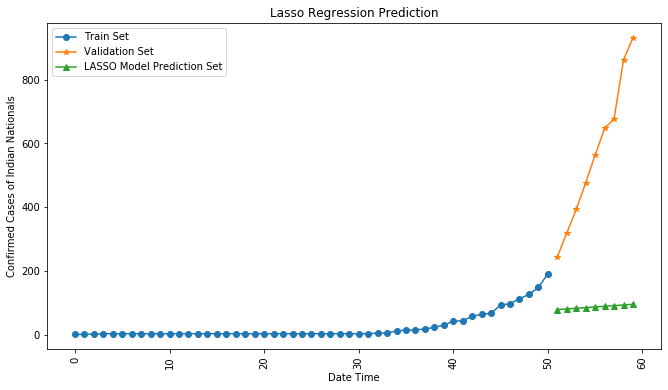

In [36]:
# plotting the predictions by the model
plt.figure(figsize = (11, 6))
plt.plot(train_ml.index, train_ml["ConfirmedIndianNational"], label = "Train Set", marker = 'o')
plt.plot(valid_ml.index, valid_ml["ConfirmedIndianNational"], label = "Validation Set", marker = '*')
plt.plot(y_pred["LASSO Regression Model Prediction"], label = "LASSO Model Prediction Set", marker = '^')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('Confirmed Cases of Indian Nationals')
plt.title("Lasso Regression Prediction")
plt.xticks(rotation = 90)

## Logistic Regression

In [37]:
# importing the requisite library and making and training the model
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(n_jobs = -1)
log_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1), np.array(train_ml["ConfirmedIndianNational"]).reshape(-1,1))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
# making the predictions
prediction_valid_logreg = log_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
y_pred["Logistic Regression Model Prediction"] = list(prediction_valid_logreg)

In [39]:
# printing the root mean square error
model_scores.append(np.sqrt(mean_squared_error(valid_ml["ConfirmedIndianNational"], prediction_valid_logreg)))
print("Root Mean Square Error for Lasso Regression: ", np.sqrt(mean_squared_error(valid_ml["ConfirmedIndianNational"], prediction_valid_logreg)))

Root Mean Square Error for Lasso Regression:  606.9452656999275


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 <a list of 9 Text xticklabel objects>)

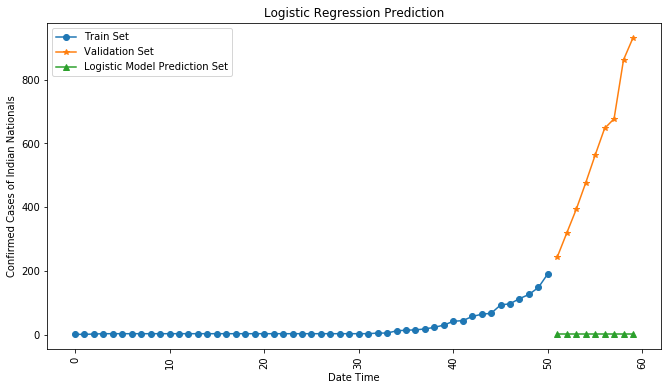

In [40]:
# plotting the predictions by the model
plt.figure(figsize = (11, 6))
plt.plot(train_ml.index, train_ml["ConfirmedIndianNational"], label = "Train Set", marker = 'o')
plt.plot(valid_ml.index, valid_ml["ConfirmedIndianNational"], label = "Validation Set", marker = '*')
plt.plot(y_pred["Logistic Regression Model Prediction"], label = "Logistic Model Prediction Set", marker = '^')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('Confirmed Cases of Indian Nationals')
plt.title("Logistic Regression Prediction")
plt.xticks(rotation = 90)

# SUMMARY

In [41]:
model_names = ["Holt's Linear", "Holt's Winter Model", "Auto-Regressive Model (AR)", "Moving Average Model (MA)", "ARIMA Model", "Linear Regression", "Polynomial Regression", "LASSO Regression", "Logistic Regression"]
summary = pd.DataFrame(zip(model_names, model_scores), columns = ["Model Name", "Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
print(summary)

                   Model Name  Root Mean Squared Error
2  Auto-Regressive Model (AR)                61.168871
3   Moving Average Model (MA)                61.168871
4                 ARIMA Model                61.168871
6       Polynomial Regression                75.846075
1         Holt's Winter Model               117.124609
0               Holt's Linear               250.491468
5           Linear Regression               527.464236
7            LASSO Regression               527.464236
8         Logistic Regression               606.945266
